## 模型描述：

$$x_1,x_2->y$$

$$y=10*x_1+2*x_2+1*x_1*x_2$$
$$y=e^{-\frac {t}{c}}$$

* 首先y是由x1，x2引起变化的
* 目前情况是只知道不同时间t条件下的y值，反推x1,x2与y的关系

## 问题分析

* 我们需要拟合$y=f(x1,x2)$,按照传统做法提取x1，x2特征，然后做拟合
* 但是我们只知道y和t的关系，因此图和从y和t的关系中提出x1,x2相关特征

## CNN处理

1D CNN 可以很好地应用于传感器数据的时间序列分析（比如陀螺仪或加速度计数据）；同样也可以很好地用于分析具有固定长度周期的信号数据（比如音频信号）

### 1.1 数据生成

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 

In [2]:
def Rand(a,b,length):
    data=[]
    for i in range(length):
        data.append(random.uniform(a,b))
    return data

In [3]:
def decay(sig1,sig2):
    data=[]
    for x1,x2 in zip(sig1,sig2):
        y=2*x1*np.exp(-t/c)+2*x2*np.exp(-t/c)
        data.append(y)
    return np.array(data)

In [4]:
c=1   #时间常数
t=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])  #观测时间

In [2]:
x1=Rand(1,100,10000)
x2=Rand(1,100,10000)
y=decay(x1,x2)

NameError: name 'Rand' is not defined

In [6]:
x1=np.array(x1).reshape(-1,1)
x2=np.array(x2).reshape(-1,1)
print("x1的大小为:",x1.shape)
print("x2的大小为:",x2.shape)
print("y的大小为:",y.shape)

x1的大小为: (10000, 1)
x2的大小为: (10000, 1)
y的大小为: (10000, 20)


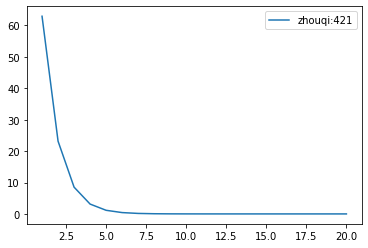

In [7]:
n=random.randint(1,1000)
plt.plot(t,y[n,:])
plt.legend(['zhouqi:%s'%n])
plt.show()

因此：我们观测值是不同周期下相同时刻段内的的$f(x)$分布。

根据生成数据可以发现：
* 如果不同时刻之间没有关系的话，那么可以按照时间分为20个模型分别取预测
* 如果不同时刻之间有关系的话，那么就不能单独20个模型去预测，要统一去预测

### 1.2 用PyTorch实现CNN用来刻画模型

In [17]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torch.utils.data as data,Dataset,DatasetLoader,TensorDataset

ModuleNotFoundError: No module named 'Dataset'

In [1]:
y=y.reshape(-1,20,1)
y_tensor=torch.from_numpy(y).reshape(-1,1,20)
print(y_tensor.size()) 

NameError: name 'y' is not defined

In [10]:
y_tensor[1]

tensor([[[4.7863e+01, 1.7608e+01, 6.4776e+00, 2.3830e+00, 8.7665e-01,
          3.2250e-01, 1.1864e-01, 4.3646e-02, 1.6056e-02, 5.9068e-03,
          2.1730e-03, 7.9940e-04, 2.9408e-04, 1.0819e-04, 3.9800e-05,
          1.4641e-05, 5.3863e-06, 1.9815e-06, 7.2896e-07, 2.6817e-07]]],
       dtype=torch.float64)

In [20]:
x=np.hstack((x1,x2))
x1_tensor=torch.from_numpy(x1)
x2_tensor=torch.from_numpy(x2)
x_tensor=torch.from_numpy(x).reshape(-1,1,2,1)
print(x1_tensor.size())
print(x2_tensor.size())
print(x_tensor.size())

torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1, 2, 1])


Conv1d参数说明：
* nn.Conv1d(in_channels,out_channels,kernel_size,stride=1.padding=0,bias=True)

In [21]:
class TEM_net(nn.Module): 
    def __init__(self):
        nn.Module.__init__(self)
        
        #定义卷积层
        self.conv_unit=nn.Sequential(
        nn.Conv1d(1,5,kernel_size=5,stride=1,padding=0),
        nn.AvgPool1d(kernel_size=2,stride=2,padding=0),
        
        nn.Conv1d(5,5,kernel_size=3,stride=1,padding=0),
        nn.AvgPool1d(kernel_size=2,stride=2,padding=0)
        )
        
        #定义全连接层
        self.fc_unit=nn.Sequential(
        nn.Linear(3*1*5,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,2)
        )
        
    #数据从此进来，经过定义好的各层网络，最终输出
    def forward(self,x):
        #batchsz=x.size(0)
        print(x.size())
        #卷积层
        x=self.conv_unit(x) 
        
        # 对数据维度作处理，以适应全连接层
        x=x.view(x.size(0),-1)
        logits=self.fc_unit(x)
        
        return logits
        

In [22]:
model=TEM_net()

In [23]:
criteon = nn.CrossEntropyLoss()

In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
batches=500
for epoch in range(100):
    for i in range(10000):
        x=y_tensor[i].to(torch.float32)
        logist = model(x) 
        oss = criteon(logist, x_tensor[i]) # 计算损失
        optimizer.zero_grad()               # 旧梯度清零
        loss.backward()                     # 误差反向传播
        optimizer.step()                    # 梯度更新
    print(epoch, loss.item())

torch.Size([1, 20])


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [5, 1, 5], but got 2-dimensional input of size [1, 20] instead